In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import pandas as pd

In [2]:
bigp = ['AL', 'BNP', 'Jamaat', 'JaPa']
mainp = ['AL', 'BNP']

In [3]:
df = pd.read_csv('data/party_result.csv')
df.head()

,year,party,votes,votes_pc,seats
0,1991,BNP,10507549,30.81,140
1,1991,AL,10259866,30.08,88
2,1991,Jamaat,4136661,12.13,18
3,1991,JaPa,4063537,11.92,35
4,1991,BAKSAL,616014,1.81,5


In [4]:
df.rename(columns={'seats': 'seats_fptp'}, inplace=True)

In [5]:
# list all electoral methods
methods = ['fptp', 'pr', 'mmp']


# D'Hondt / Jefferson method
def dhondt(votes, total_seats):
    # initialize seats and quotient
    seats = {party: 0 for party in votes}
    q = {party: 1 for party in votes}
    # loop for each seat
    for _ in range(total_seats):
        # calculate the ratio
        ratios = {party: votes[party] / q[party] for party in votes}
        # find the party with max ratio
        max_ratio_party = max(ratios, key=ratios.get)
        # give 1 seat to party with max ratio
        seats[max_ratio_party] += 1
        # increase quotient by 1 of party with max ratio
        q[max_ratio_party] += 1
    return seats


# Sainte-Laguë / Webster method
def slague(votes, total_seats):
    # initialize seats and quotient
    seats = {party: 0 for party in votes}
    q = {party: 1 for party in votes}
    # loop for each seat
    for _ in range(total_seats):
        # calculate the ratio
        ratios = {party: votes[party] / q[party] for party in votes}
        # find the party with max ratio
        max_ratio_party = max(ratios, key=ratios.get)
        # give 1 seat to party with max ratio
        seats[max_ratio_party] += 1
        # increase quotient by 2 of party with max ratio
        q[max_ratio_party] += 2
    return seats


# Mixed-member proportional (compensation using D'Hondt)
def mmp_dhondt(df, dseat, rseat):
    dfq = df.copy()
    # total = direct + reserved
    tseat = dseat + rseat
    
    # create votes and seats map of each party
    votes = dfq.set_index('party')['votes'].to_dict()
    seats = dfq.set_index('party')['seats_fptp'].to_dict()
    
    # find seats % obtained through direct election (FPTP)
    dfq['seats_fptp_pc'] = round(df[f'seats_fptp'] / dseat * 100, 2)
    
    # find the gap between votes % and seats % of each party
    dfq['seats_pc_diff'] = dfq['votes_pc'] - dfq['seats_fptp_pc']
    # get the data as a party map
    shorts = dfq.set_index('party')['seats_pc_diff'].to_dict()
    
    # remove independent candidates as they don't represent a party
    shorts.pop('Independents', None)
    shorts.pop('Independent', None)
    
    # remove parties that don't need compensation
    for party, diff in list(shorts.items()):
        if diff <= 0:
            del shorts[party]
    
    # initialize quotients for D'Hondt
    q = {party: 1 for party in shorts}
    
    # loop for each reserved seat
    for _ in range(rseat):
        # calculate the ratio
        ratios = {party: votes[party] / q[party] for party in shorts}
        # find the party with max ratio
        max_ratio_party = max(ratios, key=ratios.get)
        # give 1 seat to party with max ratio
        seats[max_ratio_party] += 1
        # increase quotient by 1 of party with max ratio
        q[max_ratio_party] += 1
        
    return seats

# Mixed-member proportional (compensate by directly adding the number of seats a party lacks)
def mmp_mod(df, dseat, rseat):
    dfq = df.copy()
    # total = direct + reserved
    tseat = dseat + rseat
    
    # create votes % and seats map of each party
    votes_pc = dfq.set_index('party')['votes_pc'].to_dict()
    seats = dfq.set_index('party')['seats_fptp'].to_dict()
    
    # calculate the number of seats a party should get using PR
    seats_pr = {party: int(vpc * tseat / 100) for party, vpc in votes_pc.items()}
    # sort in descending order
    seats_pr_sorted = sorted(seats_pr.items(), key=lambda x: x[1], reverse=True)
    
    for party, seat in seats_pr_sorted:
        # skip independent candidates as they don't represent a party
        if party == 'Independents':
            continue
        if party == 'Independent':
            continue 
        short = seat - seats[party]
        # skip parties that don't need compensation
        if short <= 0:
            continue
        # find minimum of seats short and seats available
        extra_seat = min(short, rseat)
        # give the seats to the party
        seats[party] += extra_seat
        # remove the seats from seats available
        rseat -= extra_seat
        # if no seats available, quit
        if rseat <= 0:
            break
            
    return seats

print(dhondt({'A': 40, 'B': 30, 'C': 22, 'D': 8}, 10))
print(slague({'A': 40, 'B': 30, 'C': 22, 'D': 8}, 10))

{'A': 5, 'B': 3, 'C': 2, 'D': 0}
{'A': 4, 'B': 3, 'C': 2, 'D': 1}


In [6]:
# only take data of particular year
year = 2008
df = df[df.year == year]

# get party - votes map
df_votes = df.set_index('party')['votes'].to_dict()

# apply PR and MMP methods
dh_seats = dhondt(df_votes, 300)
mmp_seats = mmp_dhondt(df, 300, 50)

# add the results to dataframe
df['seats_pr'] = df['party'].map(dh_seats)
df['seats_mmp'] = df['party'].map(mmp_seats)

df.head()

,year,party,votes,votes_pc,seats_fptp,seats_pr,seats_mmp
213,2008,AL,33634629,48.04,230,149,230
214,2008,JaPa,4926360,7.04,27,21,27
215,2008,JaSaD (Inu),506605,0.72,3,2,3
216,2008,Workers Party,262093,0.37,2,1,2
217,2008,LDP,191679,0.27,1,0,1


In [7]:
# calculate seats % for each method
for method in methods:
    tseat = 300
    if method == 'mmp':
        tseat = 350
    df[f'seats_{method}_pc'] = round(df[f'seats_{method}'] / tseat * 100, 2)
    
df.head()

,year,party,votes,votes_pc,seats_fptp,seats_pr,seats_mmp,seats_fptp_pc,seats_pr_pc,seats_mmp_pc
213,2008,AL,33634629,48.04,230,149,230,76.67,49.67,65.71
214,2008,JaPa,4926360,7.04,27,21,27,9.00,7.00,7.71
215,2008,JaSaD (Inu),506605,0.72,3,2,3,1.00,0.67,0.86
216,2008,Workers Party,262093,0.37,2,1,2,0.67,0.33,0.57
217,2008,LDP,191679,0.27,1,0,1,0.33,0.00,0.29


In [8]:
df.to_csv(f'dataout/method_big_{year}.csv', index=False)

In [9]:
# filter out winner parties data
df_winner = df[(df['seats_fptp'] + df['seats_pr'] + df['seats_mmp']) >= 1]

# split into big and small parties
df_winner_big = df_winner[df_winner.party.isin(bigp)]
df_winner_small = df_winner[~df_winner.party.isin(bigp)]

In [10]:
# rename plot method labels function
def change_method_labels(labels):
    mlist = methods + ['sl', 'dh']
    new_labels = []
    for label in labels:
        out = label.replace('_', ' ').replace('pc', '%')
        out = out.title()
        for method in mlist:
            out = out.replace(method.title(), method.upper())
        new_labels.append(out)
    return new_labels

# rename plot party labels function
def change_party_labels(labels):
    pdict = {p.lower(): p for p in df.party.to_list()}
    new_labels = []
    for label in labels:
        if label.lower() in pdict:
            new_labels.append(pdict[label.lower()])
    return new_labels

C:\Users\matus\AppData\Local\Temp\ipykernel_10060\242687169.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(change_method_labels(vcols))


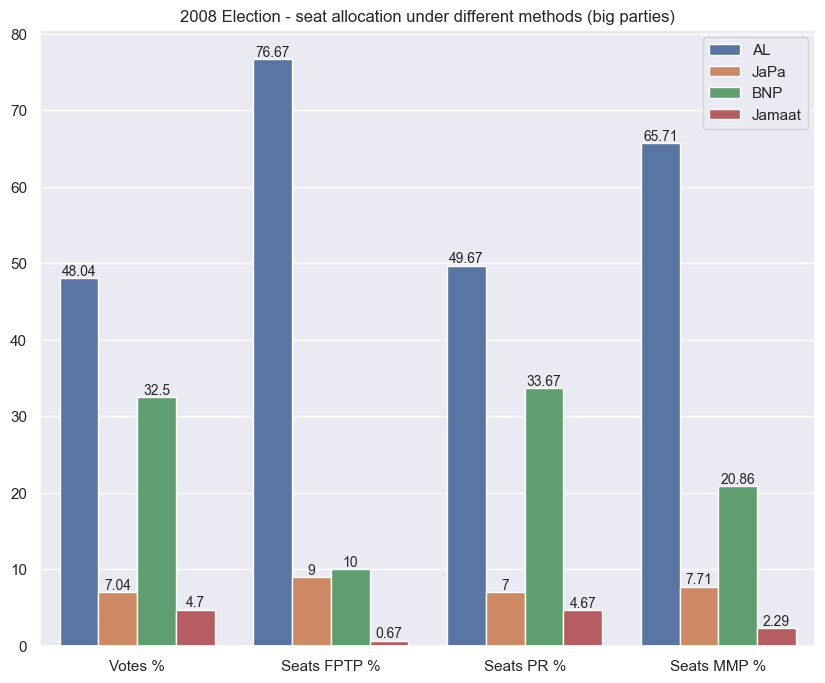

In [11]:
# melt the data for plotting big parties
vcols = ['votes_pc', 'seats_fptp_pc', 'seats_pr_pc', 'seats_mmp_pc']
melted = pd.melt(
    df_winner_big, 
    id_vars='party', 
    value_vars=vcols)

# plot seat allocation for big parties
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=melted, x='variable', y='value', hue='party', ax=ax)

# set xtick labels
ax.set_xticklabels(change_method_labels(vcols))
ax.set(xlabel="", ylabel="")

# add bar label
for cont in ax.containers:
    ax.bar_label(cont, fontsize=10)
    
# modify labels
plt.legend(loc='upper right')
handles, old_labels = ax.get_legend_handles_labels()
new_labels = change_party_labels(old_labels)
ax.legend(handles=handles, labels=new_labels)

# add title
plt.title(f'{year} Election - seat allocation under different methods (big parties)')

plt.show()

# save plot
fig.savefig(f'fig/method_big_{year}',bbox_inches='tight')

C:\Users\matus\AppData\Local\Temp\ipykernel_10060\193628208.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(change_method_labels(vcols))


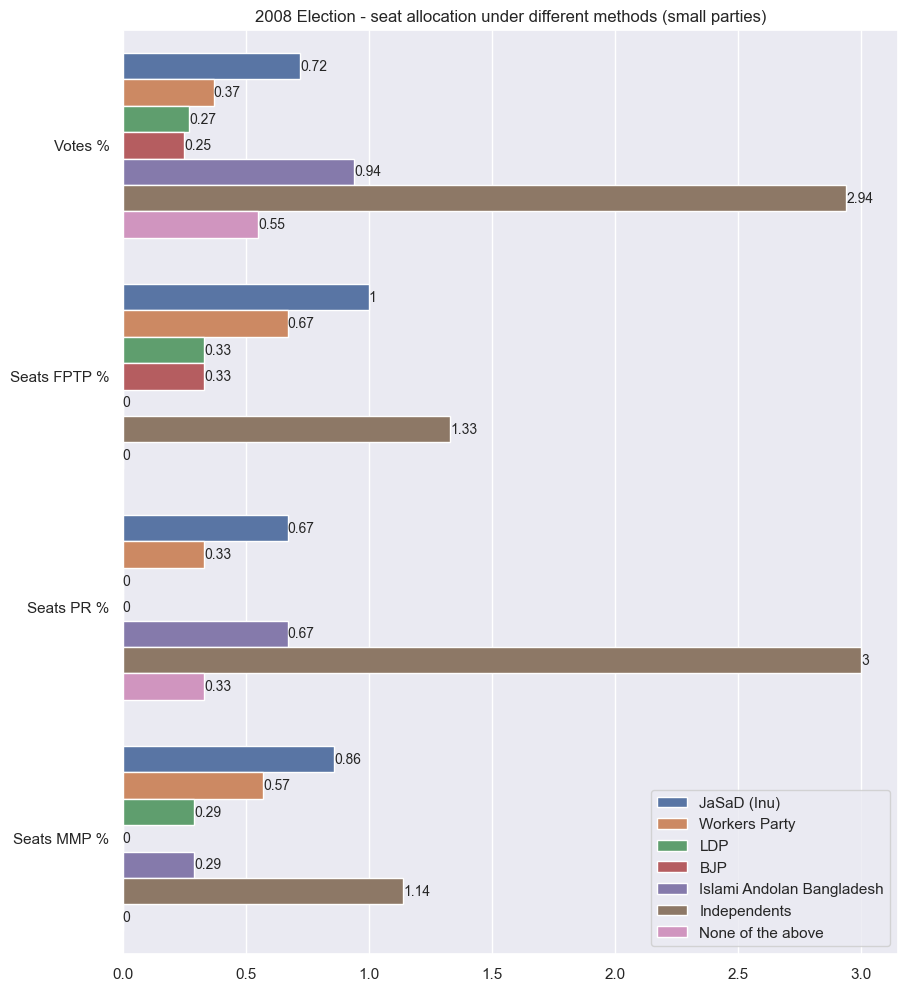

In [12]:
# melt the data for plotting small parties
vcols = ['votes_pc', 'seats_fptp_pc', 'seats_pr_pc', 'seats_mmp_pc']
melted = pd.melt(
    df_winner_small, 
    id_vars='party', 
    value_vars=vcols)

# plot seat allocation for small parties
fig, ax = plt.subplots(figsize=(10, 12))
sns.barplot(data=melted, y='variable', x='value', hue='party', ax=ax)

# set ytick labels
ax.set_yticklabels(change_method_labels(vcols))
ax.set(xlabel="", ylabel="")

# add bar label
for cont in ax.containers:
    ax.bar_label(cont, fontsize=10)
    
# modify labels
plt.legend(loc='upper right')
handles, old_labels = ax.get_legend_handles_labels()
new_labels = change_party_labels(old_labels)
ax.legend(handles=handles, labels=new_labels)

# add title
plt.title(f'{year} Election - seat allocation under different methods (small parties)')

plt.show()

# save plot
fig.savefig(f'fig/method_small_{year}',bbox_inches='tight')

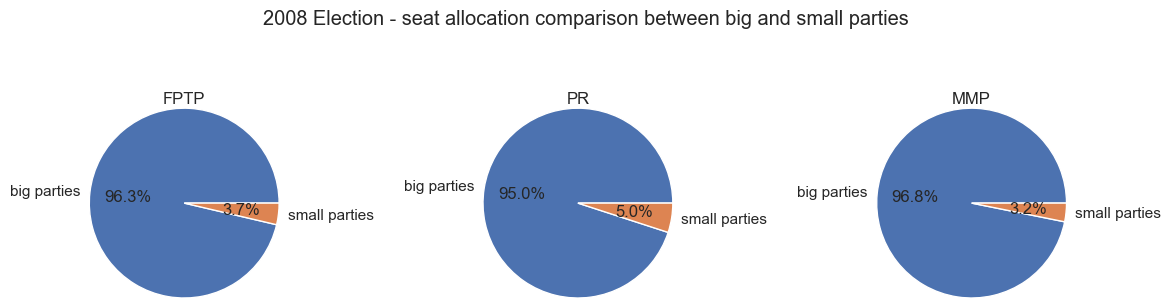

In [13]:
# plot comparison between methods for big and small parties
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, method in enumerate(methods):
    seat_sums = [
        df_winner_big[f'seats_{method}_pc'].sum(),
        df_winner_small[f'seats_{method}_pc'].sum()
    ]
    labels = ['big parties', 'small parties']
    axes[i].pie(seat_sums, labels=labels, autopct='%1.1f%%', radius = 1.3)
    axes[i].set_title(method.upper())
        
fig.tight_layout()
plt.suptitle(f'{year} Election - seat allocation comparison between big and small parties')
fig.savefig(f'fig/method_bigvsmall_{year}',bbox_inches='tight')
plt.show()

In [14]:
# calculate seats using Sainte-Laguë and MMP (modified) methods
sl_seats = slague(df_votes, 300)
mmp_mod_seats = mmp_mod(df, 300, 50)

# add the results to dataframe
df['seats_pr_sl'] = df['party'].map(sl_seats)
df['seats_mmp_mod'] = df['party'].map(mmp_mod_seats)

# calculate seats % for each method
df['seats_pr_sl_pc'] = round(df['seats_pr_sl'] / 300 * 100, 2)
df['seats_mmp_mod_pc'] = round(df['seats_mmp_mod'] / 350 * 100, 2)

df.head()

,year,party,votes,votes_pc,seats_fptp,seats_pr,seats_mmp,seats_fptp_pc,seats_pr_pc,seats_mmp_pc,seats_pr_sl,seats_mmp_mod,seats_pr_sl_pc,seats_mmp_mod_pc
213,2008,AL,33634629,48.04,230,149,230,76.67,49.67,65.71,146,230,48.67,65.71
214,2008,JaPa,4926360,7.04,27,21,27,9.00,7.00,7.71,21,27,7.00,7.71
215,2008,JaSaD (Inu),506605,0.72,3,2,3,1.00,0.67,0.86,2,3,0.67,0.86
216,2008,Workers Party,262093,0.37,2,1,2,0.67,0.33,0.57,1,2,0.33,0.57
217,2008,LDP,191679,0.27,1,0,1,0.33,0.00,0.29,1,1,0.33,0.29


In [15]:
df.to_csv(f'dataout/method_all_big_{year}.csv', index=False)

In [16]:
# filter out winner parties data
df_winner = df[(df['seats_pr_sl'] + df['seats_mmp_mod']) >= 1]

# calculate seats % for each method
df_winner_big = df_winner[df_winner.party.isin(bigp)]
df_winner_small = df_winner[~df_winner.party.isin(bigp)]

C:\Users\matus\AppData\Local\Temp\ipykernel_10060\2381705982.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(change_method_labels(vcols))


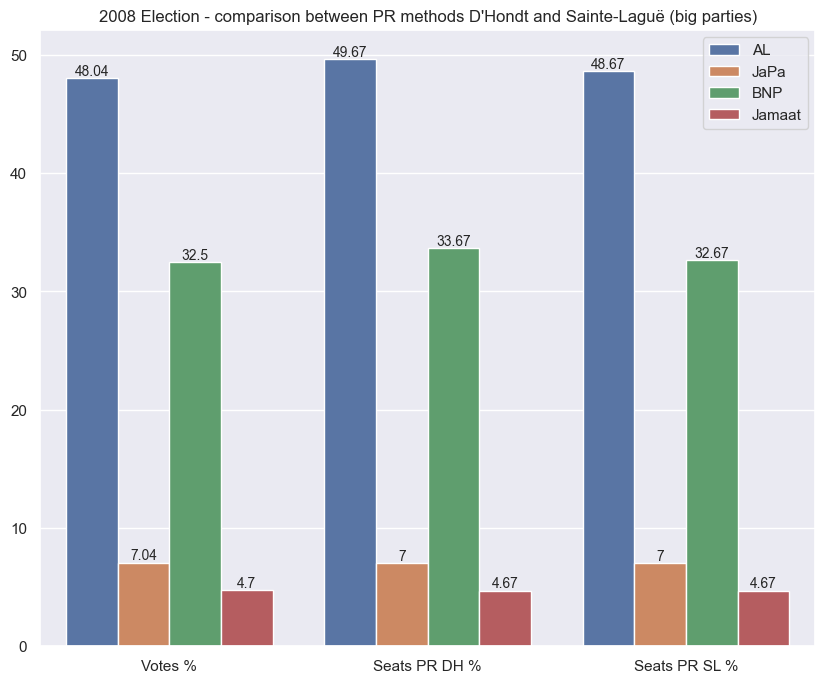

In [17]:
# melt the data for plotting big parties
vcols = ['votes_pc', 'seats_pr_dh_pc', 'seats_pr_sl_pc']
melted = pd.melt(
    df_winner_big.rename(columns={'seats_pr_pc': 'seats_pr_dh_pc'}), 
    id_vars='party', 
    value_vars=vcols
)

# plot PR method comparison for big parties
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=melted, x='variable', y='value', hue='party', ax=ax)

# set xtick labels
ax.set_xticklabels(change_method_labels(vcols))
ax.set(xlabel="", ylabel="")

# add bar label
for cont in ax.containers:
    ax.bar_label(cont, fontsize=10)

# modify labels
plt.legend(loc='upper right')
handles, old_labels = ax.get_legend_handles_labels()
new_labels = change_party_labels(old_labels)
ax.legend(handles=handles, labels=new_labels)


plt.title(f'{year} Election - comparison between PR methods D\'Hondt and Sainte-Laguë (big parties)')
plt.show()
fig.savefig(f'fig/method_pr_big_{year}',bbox_inches='tight')

C:\Users\matus\AppData\Local\Temp\ipykernel_10060\298446987.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(change_method_labels(vcols))


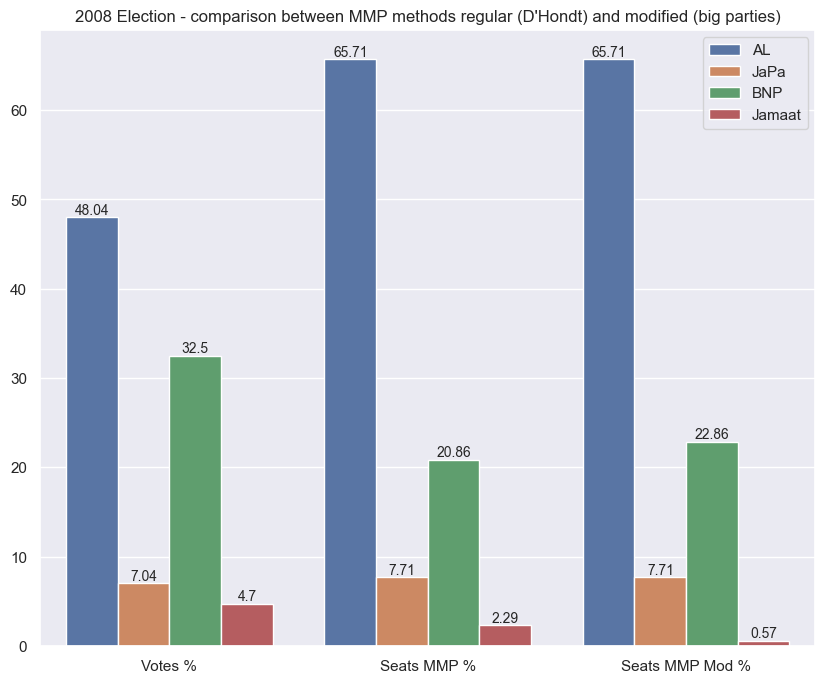

In [18]:
# melt the data for plotting big parties
vcols=['votes_pc', 'seats_mmp_pc', 'seats_mmp_mod_pc']
melted = pd.melt(
    df_winner_big, 
    id_vars='party', 
    value_vars=vcols
)

# plot MMP method comparison for big parties
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=melted, x='variable', y='value', hue='party', ax=ax)

# set xtick labels
ax.set_xticklabels(change_method_labels(vcols))
ax.set(xlabel="", ylabel="")

# add bar label
for cont in ax.containers:
    ax.bar_label(cont, fontsize=10)

# modify labels
plt.legend(loc='upper right')
handles, old_labels = ax.get_legend_handles_labels()
new_labels = change_party_labels(old_labels)
ax.legend(handles=handles, labels=new_labels)


plt.title(f'{year} Election - comparison between MMP methods regular (D\'Hondt) and modified (big parties)')
plt.show()
fig.savefig(f'fig/method_mmp_big_{year}',bbox_inches='tight')